In [1]:
import numpy as np
import cv2 
import skimage.exposure
import skimage.io
import skimage.feature
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [2]:
# вспомогательная функция
def plot_one_image(src_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение.
    
    :param src_image: np.ndarray: исходное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 1, figsize=(6.4*2, 4.8*2), constrained_layout=True)
    ax1 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    plt.show()

In [6]:
# вспомогательная функция
def plot_transform_result(src_image, transform_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение и его преобразование.
    
    :param src_image: np.ndarray: исходное изображение
    :param transform_image: np.ndarray: преобразованное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 2, figsize=(6.4*2, 4.8*2), constrained_layout=True)
    ax1, ax2 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('After conversion')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    ax2.set_title('Contours')
    ax2.imshow(transform_image, cmap=cmap)
    ax2.set_xticks([]), ax2.set_yticks([])
    plt.show()

In [4]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(155, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged

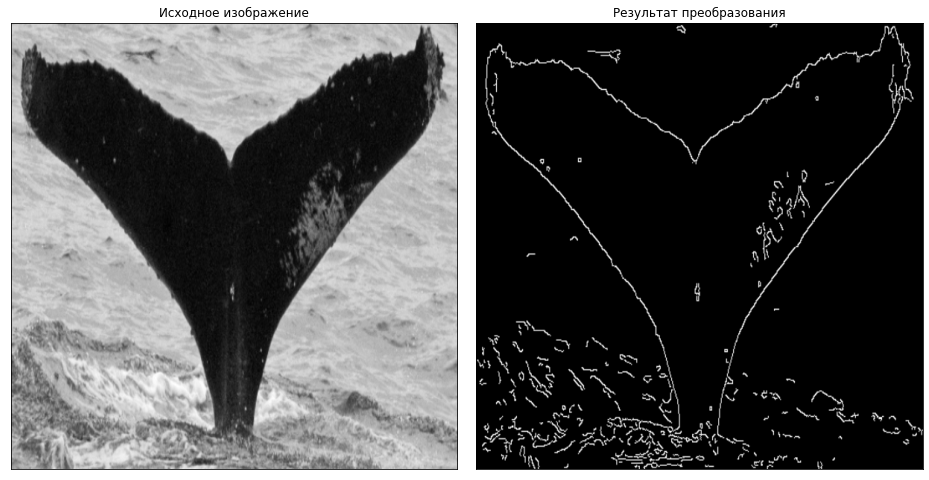

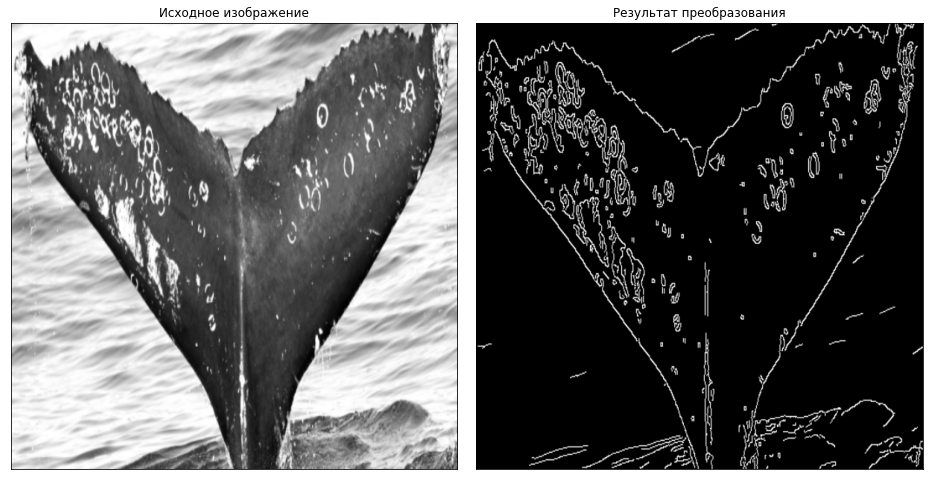

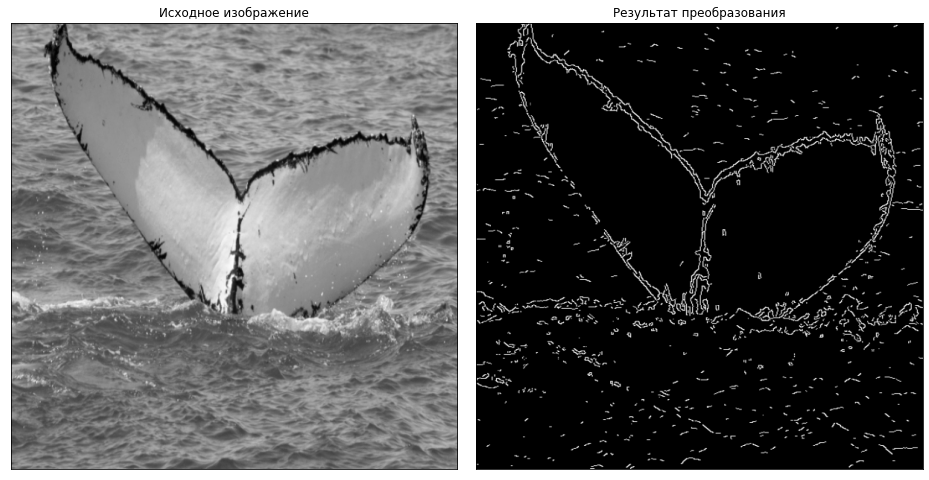

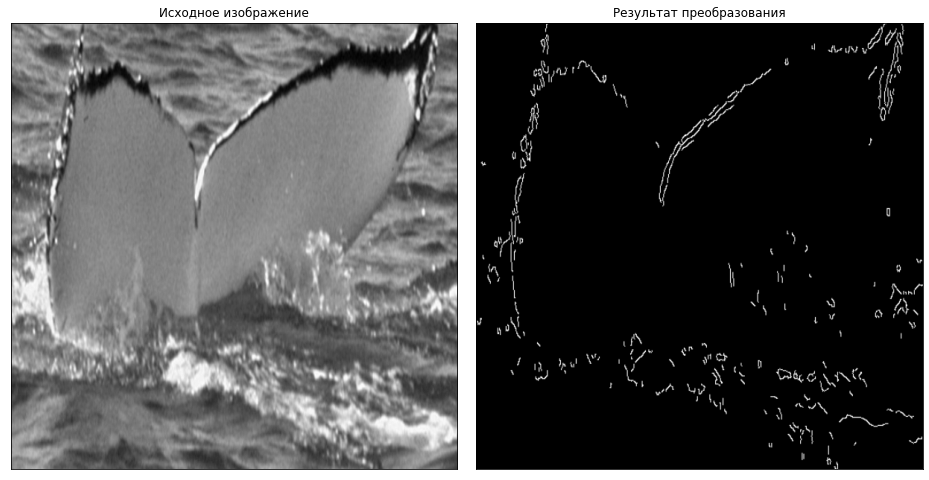

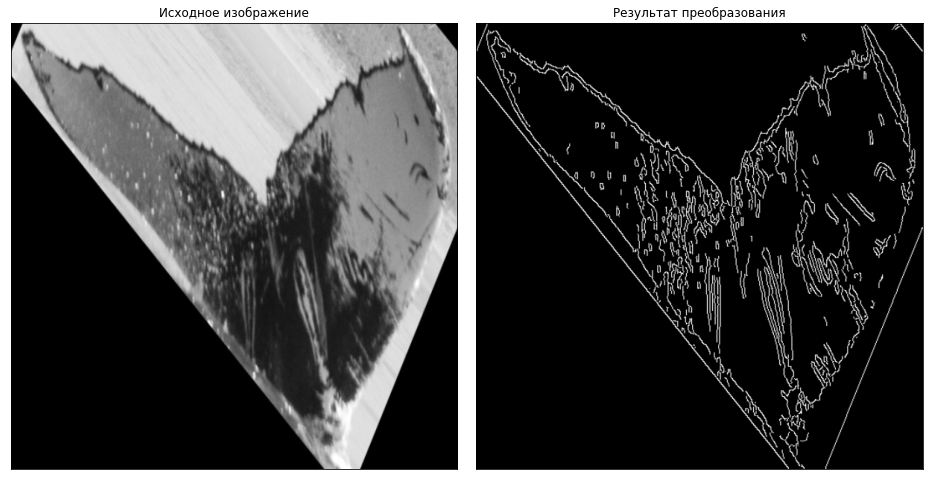

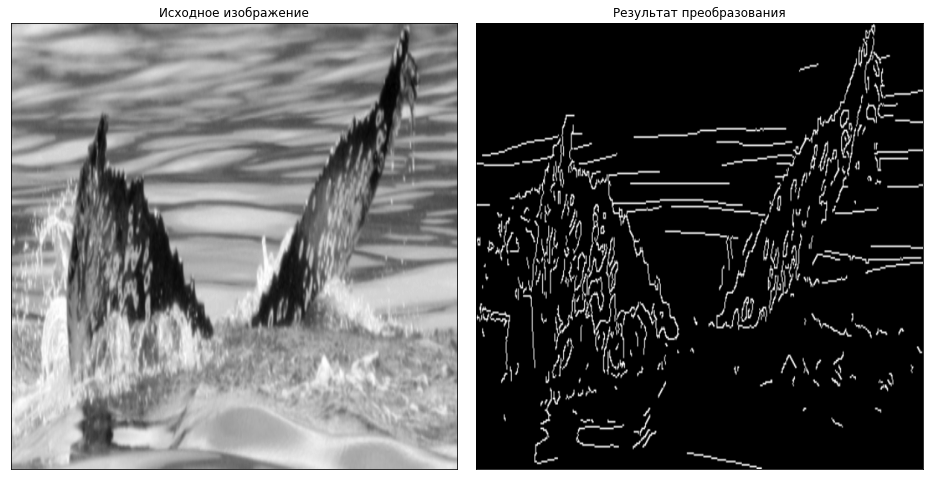

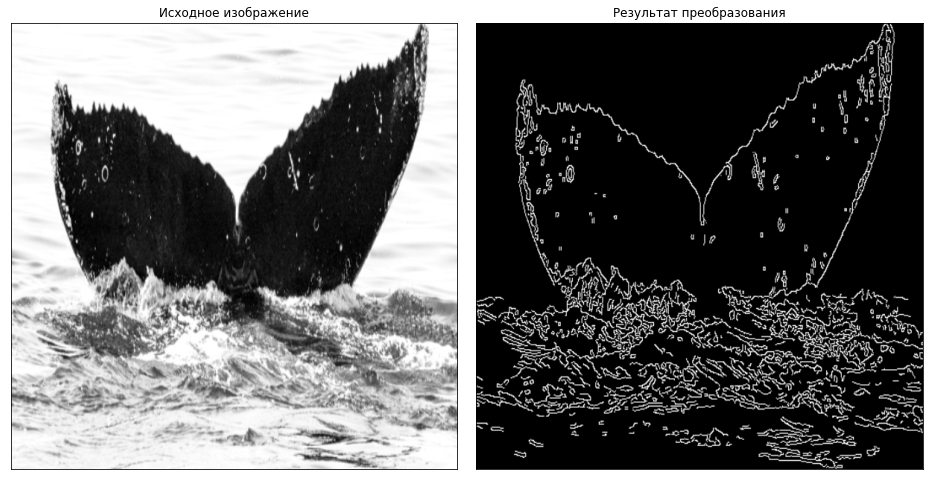

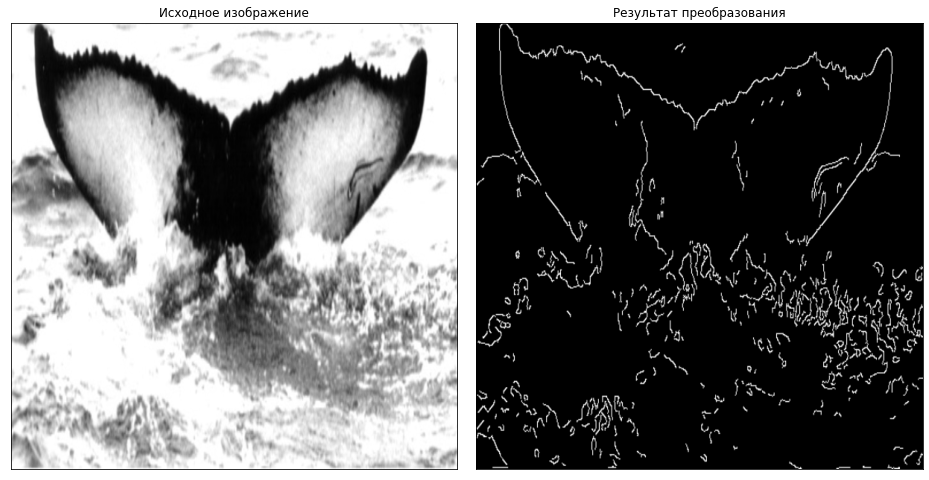

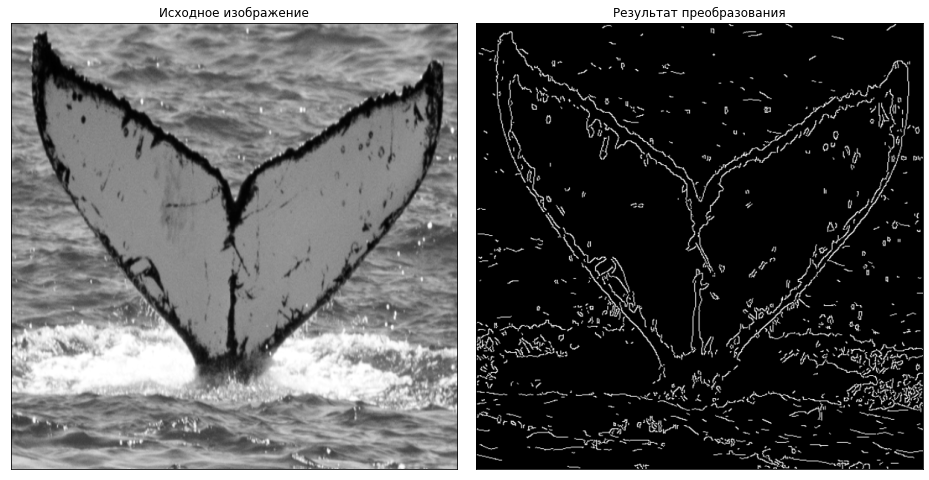

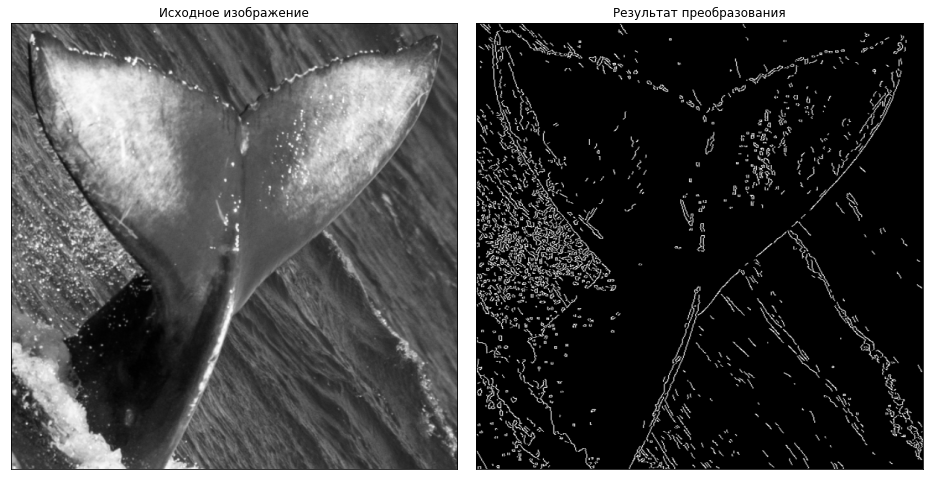

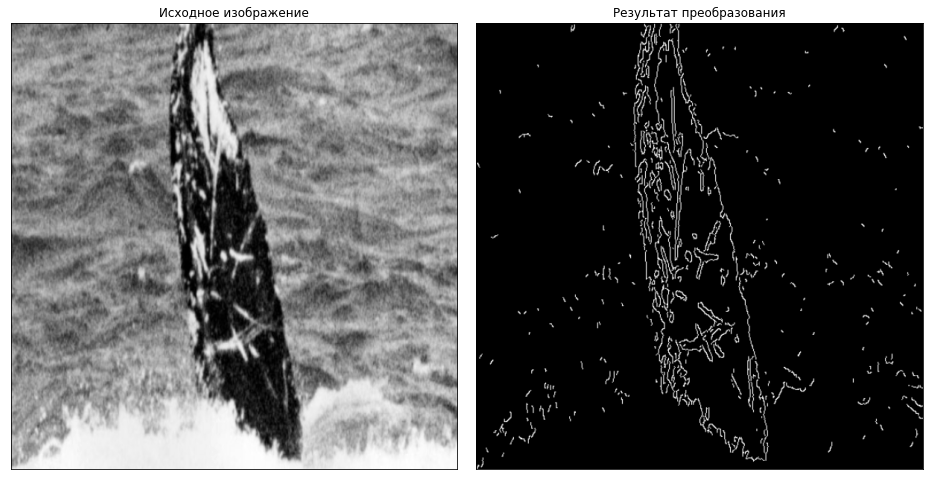

In [5]:
#sources: https://www.programmersought.com/article/2494508484/#2
from scipy.ndimage import affine_transform
 
img_shape = (1000,1000,1) # Форма изображения, используемая моделью
anisotropy = 2.15 # горизонтальная степень сжатия
crop_margin = 0.00 # Добавьте поле вокруг ограничительной рамки, чтобы компенсировать неточность ограничительной рамки
 
def build_transform(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    """
         Построить матрицу преобразования с указанными функциями
    """
    rotation        = np.deg2rad(rotation)
    shear           = np.deg2rad(shear)
    rotation_matrix = np.array([[np.cos(rotation), np.sin(rotation), 0], [-np.sin(rotation), np.cos(rotation), 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, height_shift], [0, 1, width_shift], [0, 0, 1]])
    shear_matrix    = np.array([[1, np.sin(shear), 0], [0, np.cos(shear), 0], [0, 0, 1]])
    zoom_matrix     = np.array([[1.0/height_zoom, 0, 0], [0, 1.0/width_zoom, 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, -height_shift], [0, 1, -width_shift], [0, 0, 1]])
    return np.dot(np.dot(rotation_matrix, shear_matrix), np.dot(zoom_matrix, shift_matrix))
 
def read_cropped_image(p):
    #p - picture
    # Если указан идентификатор изображения, он преобразуется в имя файла
    #if p in h2p: p = h2p[p]
    size_x,size_y = p.shape
 
         # Определить область исходного изображения для захвата на основе ограничительной рамки.
    x0,y0,x1,y1   = 100,100,p.shape[0],p.shape[1]
    dx            = x1 - x0
    dy            = y1 - y0
    x0           -= dx*crop_margin
    x1           += dx*crop_margin + 1
    y0           -= dy*crop_margin
    y1           += dy*crop_margin + 1
    if (x0 < 0     ): x0 = 0
    if (x1 > size_x): x1 = size_x
    if (y0 < 0     ): y0 = 0
    if (y1 > size_y): y1 = size_y
    dx            = x1 - x0
    dy            = y1 - y0
    if dx > dy*anisotropy:
        dy  = 0.5*(dx/anisotropy - dy)
        y0 -= dy
        y1 += dy
    else:
        dx  = 0.5*(dy*anisotropy - dx)
        x0 -= dx
        x1 += dx
 
         # Генерация матрицы преобразования
    trans = np.array([[1, 0, -0.5*img_shape[0]], [0, 1, -0.5*img_shape[1]], [0, 0, 1]])
    trans = np.dot(np.array([[(y1 - y0)/img_shape[0], 0, 0], [0, (x1 - x0)/img_shape[1], 0], [0, 0, 1]]), trans)
    if True:
        trans = np.dot(build_transform(
            0,0,1,1,
            0.08*(y1 - y0),
            0.009*(x1 - x0)
            ), trans)
    trans = np.dot(np.array([[1, 0, 0.5*(y1 + y0)], [0, 1, 0.5*(x1 + x0)], [0, 0, 1]]), trans)
     
    img = p
         # Используйте аффинное преобразование
    matrix = trans[:2,:2]
    offset = trans[:2,2]

    img    = affine_transform(img, matrix, offset, output_shape=img_shape[:-1], order=1, mode='constant', cval=np.average(img))
    
    y1=0
    y2=img.shape[1]
    x2=img.shape[0]
    for i in range(img.shape[0]):
        if len(np.unique(img[i]))<2:
            x2=i
            break
            
    for i in range(img.shape[1]//2):
        if len(np.unique(img[:,i]))>2:
            y1 = i
            break
    for i in range(img.shape[1]//2, img.shape[1]):
        if len(np.unique(img[:,i]))<2:
            y2 = i
            break
    img=img[0:x2,y1:y2]
    
    return img


def cutting(img):
    source = img
    blurred = cv2.GaussianBlur(img, (3, 3), 0)
    img = auto_canny(blurred)
    x1 = 0
    x2 = img.shape[0]
    for i in range(img.shape[0]//2):
        if len(np.unique(img[i])) == 1:
            x1 = i
        #print(len(np.unique(img[i])))
    for i in range(img.shape[0]//2,img.shape[0]):
        if len(np.unique(img[i])) == 1:
            x2 = i
            break
    source = source[x1:x2]
    img = img[x1:x2]
    
    dsize = (600, 600) # resize image 
    img = cv2.resize(img, dsize)
    source = cv2.resize(source, dsize)
    
    #for ritation need know angle...
    #M1 = cv2.getRotationMatrix2D((300, 300), 60, scale=1)
    #img = cv2.warpAffine(img, M1, (600, 600))
    
    

   #show contours
#     contours, hierarchy = cv2.findContours( img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#     cv2.drawContours(source, contours, -1, (50,40,60), 3, cv2.LINE_AA, hierarchy, 1 )
#     cv2.imshow('contours', source) # выводим итоговое изображение в окно
    return source,img

pic = os.listdir('whale_tail/')

k = 0
for i in pic:
    if k!=0:
        img = cv2.imread('whale_tail/'+i)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        out = read_cropped_image(gray)
        out,edges = cutting(out)
        plot_transform_result(out, edges, is_gray=True)
    k+=1